In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from consav.grids import nonlinspace
from consav import linear_interp

# illustrate the idea with standard CRRA utility

In [2]:
def marg_util(c,rho=2.0):
    return c**(-rho)

def inv_marg_util(u,rho=2.0):
    return u**(-1.0/rho)

In [3]:
# analytical inverse
num = 200
grid_u = nonlinspace(0.01,1.0,num,1.1)
inv = inv_marg_util(grid_u)

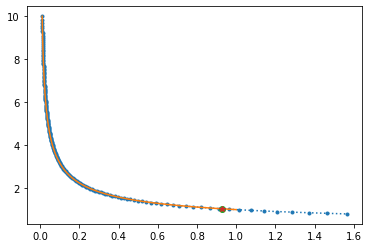

In [4]:
# numerical inverse: flip the x and y and interpolate
grid_u_inv = np.flip(nonlinspace(0.8,10.0,num,1.1))
grid_marg_u = marg_util(grid_u_inv)

def inv_marg_util_num(marg_u,grid_u_inv,grid_marg_u):
    return linear_interp.interp_1d(grid_marg_u,grid_u_inv,marg_u)
    

fig, ax = plt.subplots()

ax.plot(grid_marg_u,grid_u_inv,linestyle=':',marker='.');
ax.plot(grid_u,inv);

iU = num-6
ax.plot(grid_u[iU],inv[iU],marker='o');
ax.plot(grid_u[iU],inv_marg_util_num(grid_u[iU],grid_u_inv,grid_marg_u),marker='*');

# Do for the simple model with more complicated utility function

In [5]:
import Bargaining as brg
model = brg.HouseholdModelClass()
woman = 1
man = 2

In [6]:
def util_C(model,C_tot,iP,iL):
    par = model.par

    love = par.grid_love[iL]
    power = par.grid_power[iP]
    
    Cw_priv,Cm_priv,C_pub = brg.solve_intraperiod_couple(C_tot,power,par)
    
    Uw = brg.util(Cw_priv,C_pub,woman,par,love)
    Um = brg.util(Cm_priv,C_pub,man,par,love)
    
    return power*Uw + (1-power)*Um

def marg_util_calc(model,C_tot,iP,iL,step=1.0e-5):
    
    forward = util_C(model,C_tot+step,iP,iL)
    backward = util_C(model,C_tot-step,iP,iL)
    
    return (forward - backward)/(2*step)

def marg_util(model,C_tot,iP):
    par = model.par
    return linear_interp.interp_1d(par.grid_Ctot,par.grid_marg_u[iP],C_tot)

In [7]:
# precompute the optimal intra-temporal consumption allocation for couples given total consumption
# store marginal utility 
iL = 0 # does not matter for marginal utility
par = model.par

par.grid_marg_u = np.nan + np.ones((par.num_power,par.num_Ctot))
for iP,power in enumerate(par.grid_power):
    for i,C_tot in enumerate(par.grid_Ctot):
        if C_tot<1.00000000e-05:
            par.grid_marg_u[iP,i] = 100000.0 # some large number. should just be large enough to reduce risk of extrapolation
        else:
            par.grid_marg_u[iP,i] = marg_util_calc(model,C_tot,iP,iL)

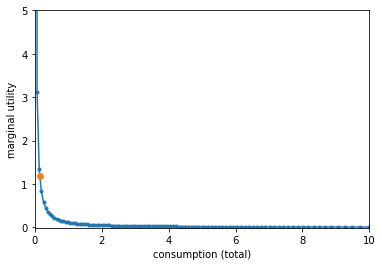

In [8]:
# marginal utility
fig, ax = plt.subplots()
ax.plot(par.grid_Ctot,par.grid_marg_u[iP],marker='.')
ax.set(xlim=(-0.01,10),ylim=(-0.01,5.0));

x = 0.15
ax.plot(x,marg_util(model,x,iP),marker='o');
ax.set(xlabel='consumption (total)',ylabel='marginal utility');

## Inverse marginal utility

In [9]:
# inverse marginal utility           
par.grid_inv_marg_u = np.flip(par.grid_Ctot)
par.grid_marg_u_for_inv = np.ones(par.grid_marg_u.shape)
for iP,power in enumerate(par.grid_power):
    par.grid_marg_u_for_inv[iP] = np.flip(par.grid_marg_u[iP])
    
def inv_marg_util(model,marg_u,iP):
    par = model.par
    return linear_interp.interp_1d(par.grid_marg_u_for_inv[iP],par.grid_inv_marg_u,marg_u)

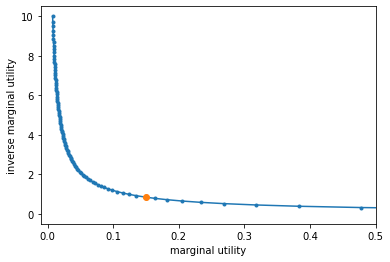

In [10]:
iP = par.num_power//2

fig, ax = plt.subplots()
ax.plot(par.grid_marg_u_for_inv[iP],par.grid_inv_marg_u,marker='.')
ax.set(xlim=(-0.01,0.5));

x = 0.15
ax.plot(x,inv_marg_util(model,x,iP),marker='o');
ax.set(xlabel='marginal utility',ylabel='inverse marginal utility');

In [11]:
# The functions "marg_util" and "inv_marg_util" can now be called
# and they will return interpolated values
marg_in = 0.15
c = inv_marg_util(model,marg_in,iP)
marg_out = marg_util(model,c,iP)

print(f'A marginal utility if {marg_in:2.3f} gives consumption of {c:2.3f}')
print(f'and the marginal utility of that consumption is {marg_out:2.3f}, which is also what we started with! (phew!)')

A marginal utility if 0.150 gives consumption of 0.847
and the marginal utility of that consumption is 0.150, which is also what we started with! (phew!)
